In [1]:
import pandas as pd
import pandas_ta as ta
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("F:\\your\\file_path\\data.csv")


In [3]:
data.drop(columns=['Volume',"Symbol"], inplace=True)


<ul>
<li>Check Color of the candle
<li>Check First 10 min High and Low
<li>Add moving average
<li>Get Long Short Signal 
<li>Run Simulation
</ul>

In [4]:
data['Datetime'] = pd.to_datetime(data['Datetime'])

data['Color_10_min'] = np.where(
    (data['Open'].shift(1)>data['Close'])&
     (data['Datetime'].dt.minute == 20)&
     (data['Datetime'].dt.hour == 9) ,"r",
     np.where((data['Open'].shift(1)<data['Close'])&
     (data['Datetime'].dt.minute == 20)&
     (data['Datetime'].dt.hour == 9),'g',np.nan))



Check First 10 min High and Low

In [5]:
data['Prv_high'] = data['High'].shift(1)
data['Prv_low'] = data['Low'].shift(1)
data['10_min_high'] = np.where(
    (data['Datetime'].dt.minute==20)&
    (data['Datetime'].dt.hour==9)&
    (data['Color_10_min'] != np.nan)&
    (data['High'].shift(1)>data['High']), 
    data['High'].shift(1),
    np.where(
        (data['Datetime'].dt.minute==20)&
        (data['Datetime'].dt.hour==9)&
        (data['Color_10_min'] != np.nan)&
        (data['High'].shift(1)<data['High']), data['High'],np.nan)
    )
data['10_min_low'] = np.where(
    (data['Datetime'].dt.minute==20)&
    (data['Datetime'].dt.hour==9)&
    (data['Color_10_min'] != np.nan)&
    (data['Low'].shift(1)>data['Low']), 
    data['Low'],
    np.where(
        (data['Datetime'].dt.minute==20)&
        (data['Datetime'].dt.hour==9)&
        (data['Color_10_min'] != np.nan)&
        (data['Low'].shift(1)<data['Low']), data['Low'].shift(1),np.nan)
    )




Add SMA 


In [ ]:
data['SMA_20'] = ta.sma(data['Close'], 20)
data['SMA_50'] = ta.sma(data['Close'], 50)
data = data[data['SMA_50']>=0]



Geting Signals

In [7]:
data['Long/Short'] = np.where(
    (data['Close']<data['SMA_20'])&
    (data['Close']<data['SMA_50'])&
    (data['Open']>data['SMA_20'])&
    (data['Color_10_min']=="r"),
    -1,
    np.where(
        (data['Close']>data['SMA_20'])&
    (data['Close']>data['SMA_50'])&
    (data['Open']>data['SMA_20'])&
    (data['Color_10_min']=="g"),
    1,np.nan
    )
)


Running Simulation

In [8]:
color = None

high = None
low = None
date_ = None
position= None
signal_generated = False
long_short = None
trade_history = pd.DataFrame(columns=["Datetime", "Entry/Exit","Position_Type","Entry_Price","Take_Profit","Take_SL","qty","EXIT_PRICE", "extime"])
entry_price = 0
sl = 0
tp = 0
initial_capital = 10000



In [ ]:
for a in data.iterrows():
    tick = a[1]
    datetime_ = dt.datetime.strptime(str(tick.iloc[0]),'%Y-%m-%d %H:%M:%S')
    time = datetime_.time()
    if datetime_.date() !=date_:
        date_ = datetime_.date()
        position  = None
        long_short = None
        signal_generated = False
    
    if time.hour==9 and time.minute==20:
        if tick.iloc[5] == "g" or tick.iloc[5]=='r':
            
            color=tick.iloc[5]
            high = tick.iloc[2]
            low = tick.iloc[3]
            signal_generated = True
            long_short = tick.iloc[-1]
            
   
    if signal_generated:
        
        if position == None:
            if  dt.time(9,20) < datetime_.time() < dt.time(12,30):

                
                if long_short == 1 and tick.iloc[4] > high:
                    entry_price = tick.iloc[4]
                    rtp = 0.01*initial_capital
                    
                    sl = tick.iloc[3]
                    tp = (entry_price-sl)*3+entry_price
                    qty = int(rtp/(entry_price-sl))
                    initial_capital -= qty*entry_price
                    trade_history.loc[len(trade_history)] = [
                        datetime_,'Entry',"Long",
                        entry_price,tp,sl,qty,0,0
                                                                ]
                    position=True
                    
                    
        elif position==True:
            #print(datetime_, entry_price, tp, sl, tick.iloc[4])
            if tick.iloc[4]>=tp:
                trade_history.loc[len(trade_history)-1,"EXIT_PRICE"] = tick.iloc[4]
                trade_history.loc[len(trade_history)-1,"extime"]=tick.iloc[0]
                initial_capital+=tick.iloc[4]*qty
                
                """trade_history.loc[len(trade_history)] = [
                    datetime_,'Exit',None,
                    None,None,None,tick.iloc[4]

                ]"""
                
                position=None
                high=None
                low=None
                signal_generated=False
                
            elif tick.iloc[4]<=sl:
                trade_history.loc[len(trade_history)-1,"EXIT_PRICE"] = tick.iloc[4]
                trade_history.loc[len(trade_history)-1,"extime"]=tick.iloc[0]
                initial_capital+=tick.iloc[4]*qty
                
                position=None
                high=None
                low=None
                signal_generated=False
            elif datetime_.time()>=dt.time(15,0):
                trade_history.loc[len(trade_history)-1,"EXIT_PRICE"] = tick.iloc[4]
                trade_history.loc[len(trade_history)-1,"extime"]=tick.iloc[0]
                initial_capital+=tick.iloc[4]*qty
                
                
                position=None
                high=None
                low=None
                signal_generated=False
                

In [10]:
trade_history['_wins'] = np.where(trade_history['Entry_Price']<trade_history['EXIT_PRICE'],
                     1,0)
print(f"Win:{trade_history['_wins'].sum()}\nLose:{len(trade_history)-trade_history['_wins'].sum()}")
print(f"Accuracy:{trade_history['_wins'].sum()/(len(trade_history)-trade_history['_wins'].sum())}")

Win:142
Lose:233
Accuracy:0.6094420600858369


In [ ]:
trade_history['pnl'] = trade_history['qty']*(trade_history['EXIT_PRICE']-trade_history['Entry_Price'])
trade_history['equity_curve']=10000 + trade_history['pnl'].cumsum()
print(trade_history)

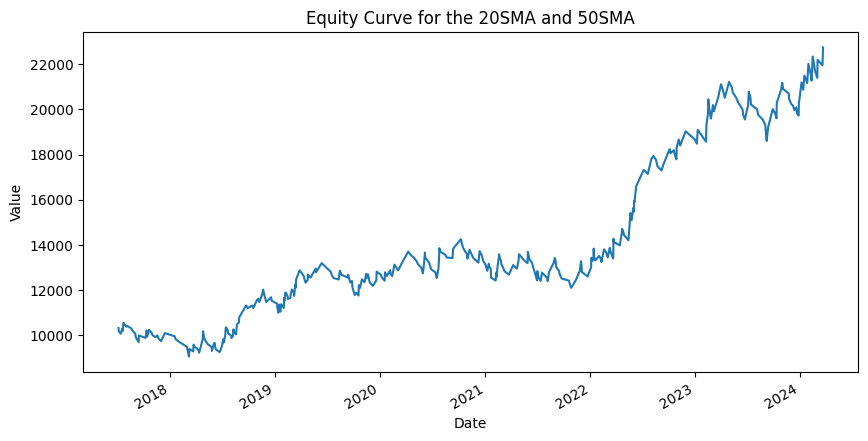

In [12]:
plt.figure(figsize=(10, 5))
plt.plot(trade_history['Datetime'], trade_history['equity_curve'], linestyle='-')
plt.gcf().autofmt_xdate()
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Equity Curve for the 20SMA and 50SMA')
plt.show()